In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

In [14]:
df_list = []
for i in [14,15,18, 19,20, 22]:
    df_list.append(pd.read_csv(f"../output/{i}/oof_df.csv"))
basic_df= df_list[0].loc[:, ["Id", "Pawpularity", "fold"]]
df_list = list(map(lambda x:x.loc[:,"preds"], df_list))

In [15]:
df = pd.concat(df_list, axis=1)
df = pd.concat([basic_df, df], axis=1)
df.head()

,Id,Pawpularity,fold,preds,preds,preds,preds,preds,preds
0,0031d6a9ef7340f898c3e05f92c7bb04,35,0,45.136406,38.146786,38.470844,40.111576,29.127243,49.617767
1,0042bc5bada6d1cf8951f8f9f0d399fa,53,0,59.318428,56.171696,57.961920,57.572533,56.101448,59.134495
2,00655425c10d4c082dd7eeb97fa4fb17,13,0,23.322584,26.374268,29.012499,26.838484,25.344923,22.351625
3,0067aaaa500b530c76b9c91af34b4cb8,98,0,71.188170,69.635570,68.687096,69.815150,70.389565,67.818960
4,006fe962f5f7e2c5f527b2e27e28ed6d,69,0,51.895363,58.869343,42.906060,50.389460,51.807327,60.133076


In [16]:
from sklearn.linear_model import Ridge
CV_score=[]
preds = []
for fold in range(5):
    df_=df.drop(columns=["Id"])
    tr_x, tr_y = df_[df_.fold!=fold].drop(columns=["Pawpularity"]), df_[df_.fold!=fold].Pawpularity
    val_x, val_y =  df_[df_.fold==fold].drop(columns=["Pawpularity"]), df_[df_.fold==fold].Pawpularity
    lr = LinearRegression()
    lr.fit(tr_x, tr_y)
    pred = lr.predict(val_x)
    preds.append(pred)
    score = np.sqrt(np.mean((np.array(pred)- np.array(val_y))**2))
    CV_score.append(score)
    print(f"fold{fold}:{score}")
print(f"CV:{sum(CV_score)/len(CV_score)}")
df['final_pred']=np.concatenate(preds)

fold0:17.304770606010116
fold1:17.314494678640102
fold2:17.340484637722817
fold3:17.500898636853133
fold4:17.227490410871415
CV:17.337627794019518


Text(114.0, 0.5, 'Pawpularity_bin')

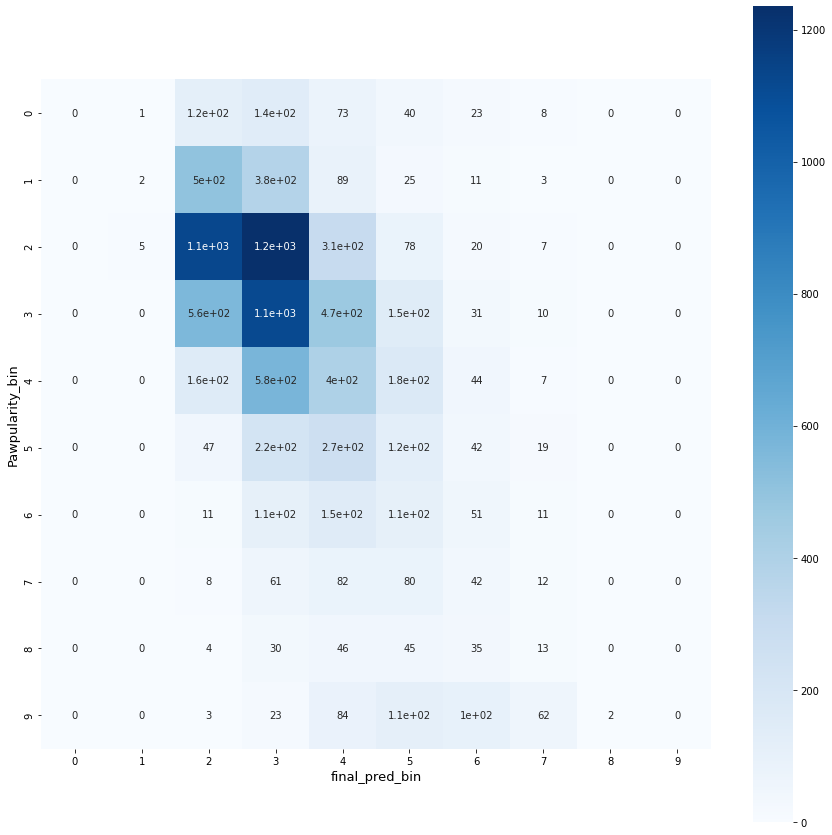

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
df["Pawpularity_bin"] = pd.cut(df["Pawpularity"], list(range(0,110, 10)), labels=False)
df["final_pred_bin"] = pd.cut(df["final_pred"], list(range(0,110, 10)), labels=False)
cm = confusion_matrix(df["Pawpularity_bin"], df['final_pred_bin'])
plt.figure(figsize=(15,15))
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.xlabel("final_pred_bin", fontsize=13)
plt.ylabel("Pawpularity_bin", fontsize=13)
# sns.scatterplot(df["Pawpularity"][:100], df['final_pred'][:100])

In [6]:
(df.Pawpularity==100).sum()

288